In [2]:
## read the data
import scipy.io
data1 = scipy.io.loadmat('/Users/jinyanwei/Desktop/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')

In [3]:
fs =125 # Sample rate in Hz

import numpy as np
def straighten_ecg(ecg_signal):
    detrended_ecg = np.subtract(ecg_signal, np.mean(ecg_signal))
    return detrended_ecg
    
import numpy as np
def normalize_sinal(ppg):
# Assuming ppg_signal and ecg_signal are your original PPG and ECG signals
    ppg_min = np.min(ppg)
    ppg_max = np.max(ppg)
    normalized_ppg = (ppg - ppg_min) / (ppg_max - ppg_min)
    return normalized_ppg

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def align_ppgbp(ppg_signal, bp_signal1, bp_signal2, ecg_signal, show=0): ## ppg_signal = ppg_normalized, bp_signal = bp_normalized, ecg_signal = ecg_normalized; get ppg_aligned, bp_aligned
    ppg_peaks, _ = find_peaks(ppg_signal, height=0.5)  # Adjust the height threshold as needed
    bp_peaks, _ = find_peaks(bp_signal1, height=0.4)
    ecg_peaks, _ = find_peaks(ecg_signal, height=0.65)
    #print(f'ppg peaks: {len(ppg_peaks)} {ppg_peaks}')
    #print(f'ecg peaks: {len(ecg_peaks)} {ecg_peaks}')

    first_ecg_peak = ecg_peaks[0]
    #print(f'first ecg peak: {first_ecg_peak}')
    indices_ppg = np.argwhere(ppg_peaks[:10] > first_ecg_peak)
    first_ppg_peak = ppg_peaks[int(indices_ppg[0])]
    #print(f'first ppg peak: {first_ppg_peak}')
    indices_bp = np.argwhere(bp_peaks[:10] > first_ecg_peak)
    first_bp_peak = bp_peaks[int(indices_bp[0])]
    #print(f'first bp peak: {first_bp_peak}')
    ppg_bp_peaks_subtraction = abs(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+5] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+5])
    #print(ppg_bp_peaks_subtraction)
    distance_ppgbp = np.bincount(ppg_bp_peaks_subtraction).argmax()
    #print(move_distance)
    #print(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(f'distance:{distance_ppgbp}')
    if first_bp_peak > first_ppg_peak:
        bp_aligned = bp_signal1[distance_ppgbp:]
        bp_ori_aligned = bp_signal2[distance_ppgbp:]
        ppg_aligned = ppg_signal
    elif first_bp_peak < first_ppg_peak:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal[distance_ppgbp:]
    else:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal
    #print(f'ppg len: {len(ppg_aligned)}')
    #print(f'bp len: {len(bp_aligned)}')
    min_len = min(len(bp_aligned), len(ppg_aligned))
    ppg_aligned = ppg_aligned[:min_len]
    bp_aligned = bp_aligned[:min_len]
    bp_ori_aligned = bp_ori_aligned[:min_len]
    ecg_aligned = ecg_signal[:min_len]
    
    if show == 1:
        plt.figure(figsize=(30, 6))
        plt.plot(ppg_signal, label='PPG')
        plt.plot(bp_signal1, label='BP')
        plt.plot(ecg_signal, label='ECG')
        plt.scatter(ppg_peaks, ppg_signal[ppg_peaks], color='c', marker='o', label='Aligned PPG Peaks')
        plt.scatter(bp_peaks, bp_signal1[bp_peaks], color='orange', marker='o', label='Aligned BP Peaks')
        plt.scatter(ecg_peaks, ecg_signal[ecg_peaks], color='green', marker='o', label='Aligned BP Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(30, 6))
        plt.plot(ppg_aligned, label='PPG')
        plt.plot(bp_aligned, label='BP')
        plt.plot(ecg_aligned, label='ECG')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return ppg_aligned, bp_aligned, bp_ori_aligned, ecg_aligned
# Reshape
def reshape_data(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i+time_steps-1])
    return np.array(Xs), np.array(ys) 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.losses import mean_squared_error

def custom_loss(y_true, y_pred):
    loss = mean_squared_error(y_true*250, y_pred*250)
    return loss

def bpwave_lstm_model(X_train, y_train, time_steps):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, X_train.shape[-1])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss=custom_loss)
    model.fit(X_train, y_train, epochs=200, verbose=1)
    return model

import matplotlib.pyplot as plt
def show_one(signal1):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1)
    return plt.show()
def show_two(signal1, signal2):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.legend()
    return plt.show()
def show_three(signal1, signal2, signal3):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.plot(signal3, label='3')
    plt.legend()
    return plt.show()

In [5]:
for patient in range(1):
    patient_data = data1['p'][0, patient][0, :]
    if len(patient_data) > 4000:
        #print(patient)
        patient_data = data1['p'][0, patient][:, :4000]
        ppg_ori = patient_data[0]
        bp_ori = patient_data[1]
        ecg_ori = patient_data[2]
        ecg_detrened = straighten_ecg(ecg_ori)
        ppg_normalized = normalize_sinal(ppg_ori)
        bp_standarded = bp_ori / 130
        ecg_normalized = normalize_sinal(ecg_detrened)
        ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented = align_ppgbp(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
patients_list = [1,3,5,16,23,24,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,44,45,46,63,67,70,71,73,76,78,79,80,81,82,103,104,120,128,129,151,156,158,161,170,172,173,183,186,187,192,193,194,196,197,198,199,200,201,203,206,207,213,214,218,220,221,227,229,236,243,248,253,254,284,286,295,298,299,303,304,305,317,336,338,343,344,346,348,350,351,355,356,357,368,369,371,372,403,412]
#print(len(patients_list))   

In [6]:
train_ppgs = []
train_ecgs = []
train_bps = []
train_bp_oris = []
test_ppgs = []
test_ecgs = []
test_bps = []
test_bp_oris = []
for patient in patients_list[:80]:
    patient_data = data1['p'][0,patient][:,:4000]
    ppg_ori = patient_data[0]
    bp_ori = patient_data[1]
    ecg_ori = patient_data[2]
    ecg_detrened = straighten_ecg(ecg_ori)
    ppg_normalized = normalize_sinal(ppg_ori)
    bp_standarded = bp_ori / 250
    ecg_normalized = normalize_sinal(ecg_detrened)
    ppg_aligned, bp_aligned, bp_ori_aligned, ecg_aligned = align_ppgbp(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
    train_ppgs.append(ppg_aligned)
    train_ecgs.append(ecg_aligned)
    train_bps.append(bp_aligned)
    train_bp_oris.append(bp_ori_aligned)
for patient in patients_list[80:100]:
    patient_data = data1['p'][0,patient][:,:4000]
    ppg_ori = patient_data[0]
    bp_ori = patient_data[1]
    ecg_ori = patient_data[2]
    ecg_detrened = straighten_ecg(ecg_ori)
    ppg_normalized = normalize_sinal(ppg_ori)
    bp_standarded = bp_ori / 250
    ecg_normalized = normalize_sinal(ecg_detrened)
    ppg_aligned, bp_aligned, bp_ori_aligned, ecg_aligned = align_ppgbp(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
    train_ppgs.append(ppg_aligned[:int(0.2*len(ppg_aligned))])
    train_ecgs.append(ecg_aligned[:int(0.2*len(ecg_aligned))])
    train_bps.append(bp_aligned[:int(0.2*len(bp_aligned))]) 
    train_bp_oris.append(bp_ori_aligned[:int(0.2*len(bp_ori_aligned))]) 
    test_ppgs.append(ppg_aligned[int(0.2*len(ppg_aligned)):])
    test_ecgs.append(ecg_aligned[int(0.2*len(ecg_aligned)):])
    test_bps.append(bp_aligned[int(0.2*len(bp_aligned)):])  
    test_bp_oris.append(bp_ori_aligned[int(0.2*len(bp_ori_aligned)):])  
train_ppg = np.concatenate(train_ppgs, axis=0)
train_ecg = np.concatenate(train_ecgs, axis=0)
train_bp = np.concatenate(train_bps, axis=0)
train_bp_ori = np.concatenate(train_bp_oris, axis=0)
train_feature = np.column_stack((train_ppg, train_ecg)) 

In [ ]:
time_steps = 15
X_train, y_train = reshape_data(train_feature,train_bp,time_steps)
bpwave_lstm_model = bpwave_lstm_model(X_train, y_train, time_steps)
bpwave_lstm_model.save('bpwave_lstm_model100.h5')

In [48]:
# time_steps = 15
# X_train, y_train = reshape_data(train_feature,train_bp,time_steps)
# bpwave_lstm_model = bpwave_lstm_model(X_train, y_train, time_steps)
# bpwave_lstm_model.save('bpwave_lstm_model100.h5')
#from keras.models import load_model
#bpwave_lstm_model = load_model('lstm_model.h5')
import pandas as pd
pred_bps = []
cc_df = pd.DataFrame(columns=(('refbp_estbp_cc', 'refbp_ppg_cc', 'refbp_ecg_cc', 'refbp_estbp_md', 'refbp_estbp_sd')))

for i in range(len(test_bps)):
    test_ppg = test_ppgs[i]
    test_ecg = test_ecgs[i]
    # X_test = np.column_stack((test_ppg, test_ecg)) 
    # y_test = test_bps[i]
    test_feature = np.column_stack((test_ppg, test_ecg))
    X_test, y_test = reshape_data(test_feature, test_bps[i], time_steps)
    y_pred = bpwave_lstm_model.predict(X_test)
    # y_test = y_test.reshape(-1)
    # y_pred = y_pred.reshape(-1)
    # test_ppg = test_ppg.reshape(-1)
    # test_ecg = test_ecg.reshape(-1)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()
    test_ppg = test_ppg[:-time_steps]
    test_ecg = test_ecg[:-time_steps]
    print(y_test.shape, y_pred.shape, test_ppg.shape, test_ecg.shape)
    pred_bps.append(y_pred)
    md = np.mean(y_pred*250-y_test*250)
    std = np.std(y_pred*250-y_test*250)
    cc_refbp_estbp = np.corrcoef(y_test, y_pred)[0, 1]
    print(cc_refbp_estbp)
    cc_refbp_ppg = np.corrcoef(y_test, test_ppg)[0, 1]
    cc_refbp_ecg = np.corrcoef(y_test, test_ecg)[0, 1]
    cc_refbp_estbp = np.abs(cc_refbp_estbp)
    print(cc_refbp_estbp)
    cc_refbp_ppg = np.abs(cc_refbp_ppg)
    cc_refbp_ecg = np.abs(cc_refbp_ecg)
    cc_df.loc[len(cc_df)] = [cc_refbp_estbp, cc_refbp_ppg, cc_refbp_ecg, md, std]

cc_df.loc[len(cc_df)] = [np.mean(cc_df['refbp_estbp_cc']), np.mean(cc_df['refbp_ppg_cc']), np.mean(cc_df['refbp_ecg_cc']), np.mean(cc_df['refbp_estbp_md']), np.mean(cc_df['refbp_estbp_sd'])]
cc_df = cc_df.rename(index={len(cc_df)-1: 'ave'})
cc_df.to_csv('100bpppgecgcc20.csv')

99/99 [==============================] - 1s 5ms/step
(3153,) (3153,) (3153,) (3153,)
0.9848887654562962
0.9848887654562962
99/99 [==============================] - 1s 6ms/step
(3153,) (3153,) (3153,) (3153,)
0.9874882622612943
0.9874882622612943
99/99 [==============================] - 1s 5ms/step
(3152,) (3152,) (3152,) (3152,)
0.9875256009030343
0.9875256009030343
99/99 [==============================] - 1s 6ms/step
(3159,) (3159,) (3159,) (3159,)
0.985214689604671
0.985214689604671
99/99 [==============================] - 1s 5ms/step
(3157,) (3157,) (3157,) (3157,)
0.9750018113172981
0.9750018113172981
99/99 [==============================] - 0s 5ms/step
(3153,) (3153,) (3153,) (3153,)
0.9571932818898129
0.9571932818898129
99/99 [==============================] - 1s 5ms/step
(3161,) (3161,) (3161,) (3161,)
0.9786767872605804
0.9786767872605804
99/99 [==============================] - 1s 6ms/step
(3160,) (3160,) (3160,) (3160,)
0.9689801167159556
0.9689801167159556
99/99 [===========

Epoch 1/200
99/99 [==============================] - 3s 7ms/step - loss: 474.2787
Epoch 2/200
99/99 [==============================] - 1s 7ms/step - loss: 124.8536
Epoch 3/200
99/99 [==============================] - 1s 6ms/step - loss: 102.4071
Epoch 4/200
99/99 [==============================] - 1s 6ms/step - loss: 82.6937
Epoch 5/200
99/99 [==============================] - 1s 6ms/step - loss: 70.1853
Epoch 6/200
99/99 [==============================] - 1s 6ms/step - loss: 63.9129
Epoch 7/200
99/99 [==============================] - 1s 7ms/step - loss: 58.9474
Epoch 8/200
99/99 [==============================] - 1s 8ms/step - loss: 64.1505
Epoch 9/200
99/99 [==============================] - 1s 7ms/step - loss: 53.8259
Epoch 10/200
99/99 [==============================] - 1s 7ms/step - loss: 54.2484
Epoch 11/200
99/99 [==============================] - 1s 8ms/step - loss: 49.3699
Epoch 12/200
99/99 [==============================] - 1s 7ms/step - loss: 53.8821
Epoch 13/200
99/99 [==

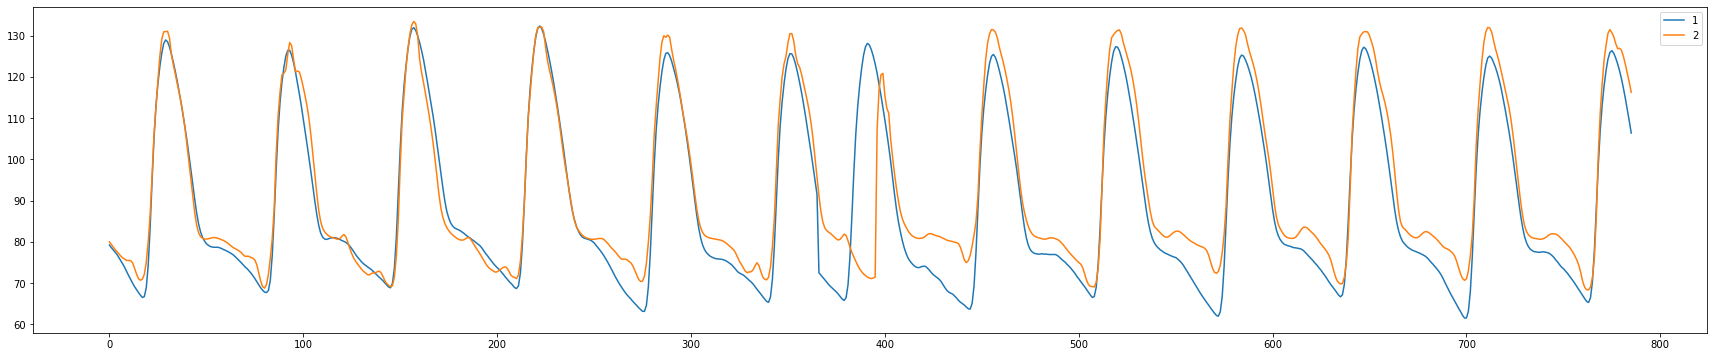

In [14]:
time_steps = 8
feature0 = np.column_stack((train_ppgs[0], train_ecgs[0])) 
bp0 = train_bps[0]
X_train0, y_train0 = reshape_data(feature0[:int(0.8*len(feature0))],bp0[:int(0.8*len(bp0))],time_steps)
model0 = bpwave_lstm_model(X_train0,y_train0,time_steps)

X_test0, y_test0 = reshape_data(feature0[int(0.8*len(feature0)):],bp0[int(0.8*len(bp0)):],time_steps)
y_pred0 = model0.predict(X_test0)
mae = np.mean(np.abs(y_pred0*250 - y_test0*250))
rmse = np.sqrt(np.mean((y_pred0*250-y_test0*250)**2))
print(f'MAE: {mae}, RMSE: {rmse}')
show_two(y_test0*250, y_pred0*250)

Epoch 1/200
99/99 [==============================] - 5s 10ms/step - loss: 460.3205
Epoch 2/200
99/99 [==============================] - 1s 11ms/step - loss: 116.7591
Epoch 3/200
99/99 [==============================] - 1s 10ms/step - loss: 86.8258
Epoch 4/200
99/99 [==============================] - 1s 10ms/step - loss: 69.2746
Epoch 5/200
99/99 [==============================] - 1s 10ms/step - loss: 63.7465
Epoch 6/200
99/99 [==============================] - 1s 11ms/step - loss: 59.5381
Epoch 7/200
99/99 [==============================] - 1s 11ms/step - loss: 56.4812
Epoch 8/200
99/99 [==============================] - 1s 13ms/step - loss: 57.2518
Epoch 9/200
99/99 [==============================] - 1s 11ms/step - loss: 51.4218
Epoch 10/200
99/99 [==============================] - 1s 12ms/step - loss: 51.2822
Epoch 11/200
99/99 [==============================] - 1s 10ms/step - loss: 47.0982
Epoch 12/200
99/99 [==============================] - 1s 12ms/step - loss: 51.7821
Epoch 13/20

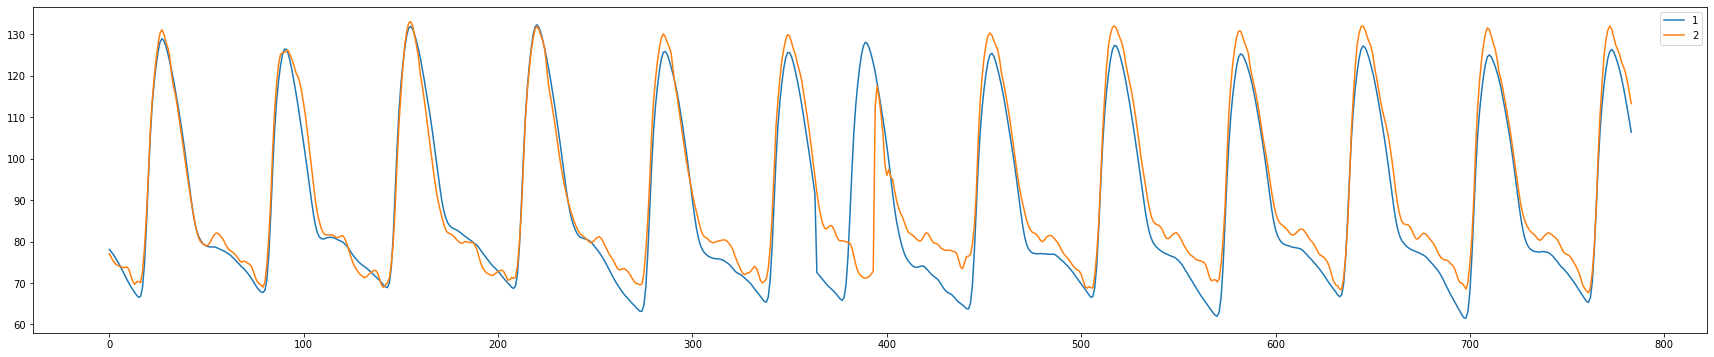

In [12]:
time_steps = 10
feature0 = np.column_stack((train_ppgs[0], train_ecgs[0])) 
bp0 = train_bps[0]
X_train0, y_train0 = reshape_data(feature0[:int(0.8*len(feature0))],bp0[:int(0.8*len(bp0))],time_steps)
model0 = bpwave_lstm_model(X_train0,y_train0,time_steps)

X_test0, y_test0 = reshape_data(feature0[int(0.8*len(feature0)):],bp0[int(0.8*len(bp0)):],time_steps)
y_pred0 = model0.predict(X_test0)
mae = np.mean(np.abs(y_pred0*250 - y_test0*250))
rmse = np.sqrt(np.mean((y_pred0*250-y_test0*250)**2))
print(f'MAE: {mae}, RMSE: {rmse}')
show_two(y_test0*250, y_pred0*250)

Epoch 1/200
99/99 [==============================] - 4s 13ms/step - loss: 487.3275
Epoch 2/200
99/99 [==============================] - 1s 13ms/step - loss: 113.3821
Epoch 3/200
99/99 [==============================] - 1s 13ms/step - loss: 77.9696
Epoch 4/200
99/99 [==============================] - 2s 17ms/step - loss: 74.2355
Epoch 5/200
99/99 [==============================] - 2s 17ms/step - loss: 63.4809
Epoch 6/200
99/99 [==============================] - 2s 16ms/step - loss: 61.4446
Epoch 7/200
99/99 [==============================] - 2s 17ms/step - loss: 54.6343
Epoch 8/200
99/99 [==============================] - 1s 14ms/step - loss: 53.6435
Epoch 9/200
99/99 [==============================] - 1s 14ms/step - loss: 49.0803
Epoch 10/200
99/99 [==============================] - 1s 14ms/step - loss: 50.9961
Epoch 11/200
99/99 [==============================] - 1s 15ms/step - loss: 50.4839
Epoch 12/200
99/99 [==============================] - 1s 14ms/step - loss: 49.6519
Epoch 13/20

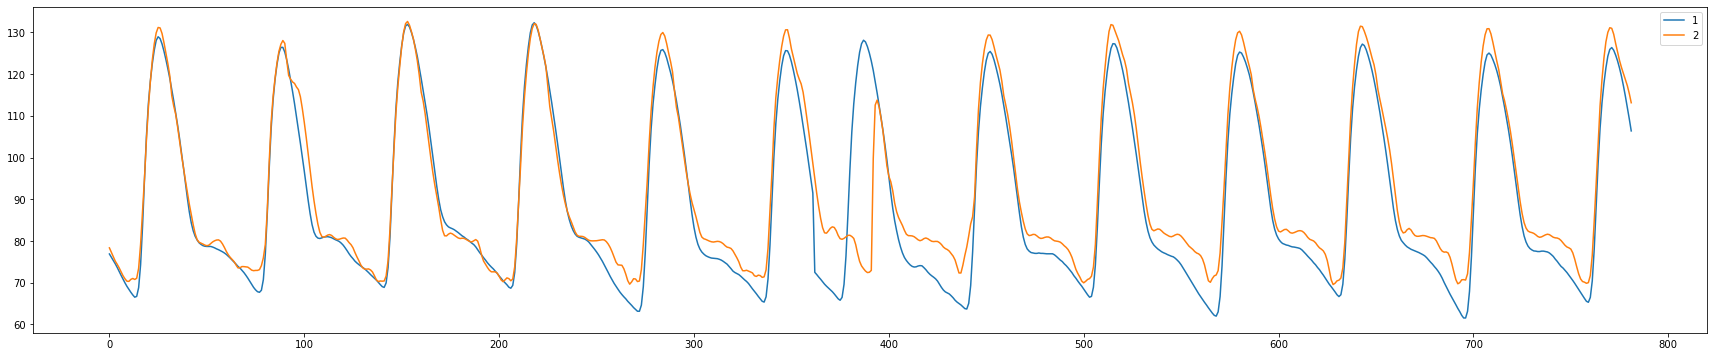

In [11]:
time_steps = 12
feature0 = np.column_stack((train_ppgs[0], train_ecgs[0])) 
bp0 = train_bps[0]
X_train0, y_train0 = reshape_data(feature0[:int(0.8*len(feature0))],bp0[:int(0.8*len(bp0))],time_steps)
model0 = bpwave_lstm_model(X_train0,y_train0,time_steps)

X_test0, y_test0 = reshape_data(feature0[int(0.8*len(feature0)):],bp0[int(0.8*len(bp0)):],time_steps)
y_pred0 = model0.predict(X_test0)
mae = np.mean(np.abs(y_pred0*250 - y_test0*250))
rmse = np.sqrt(np.mean((y_pred0*250-y_test0*250)**2))
print(f'MAE: {mae}, RMSE: {rmse}')
show_two(y_test0*250, y_pred0*250)

Epoch 1/200
99/99 [==============================] - 5s 16ms/step - loss: 387.7653
Epoch 2/200
99/99 [==============================] - 1s 14ms/step - loss: 106.9706
Epoch 3/200
99/99 [==============================] - 1s 14ms/step - loss: 76.4642
Epoch 4/200
99/99 [==============================] - 1s 14ms/step - loss: 67.2421
Epoch 5/200
99/99 [==============================] - 2s 19ms/step - loss: 59.9029
Epoch 6/200
99/99 [==============================] - 2s 17ms/step - loss: 56.8675
Epoch 7/200
99/99 [==============================] - 2s 16ms/step - loss: 51.9684
Epoch 8/200
99/99 [==============================] - 2s 17ms/step - loss: 51.8942
Epoch 9/200
99/99 [==============================] - 2s 15ms/step - loss: 48.4076
Epoch 10/200
99/99 [==============================] - 2s 17ms/step - loss: 51.2306
Epoch 11/200
99/99 [==============================] - 2s 17ms/step - loss: 48.1675
Epoch 12/200
99/99 [==============================] - 2s 19ms/step - loss: 43.5606
Epoch 13/20

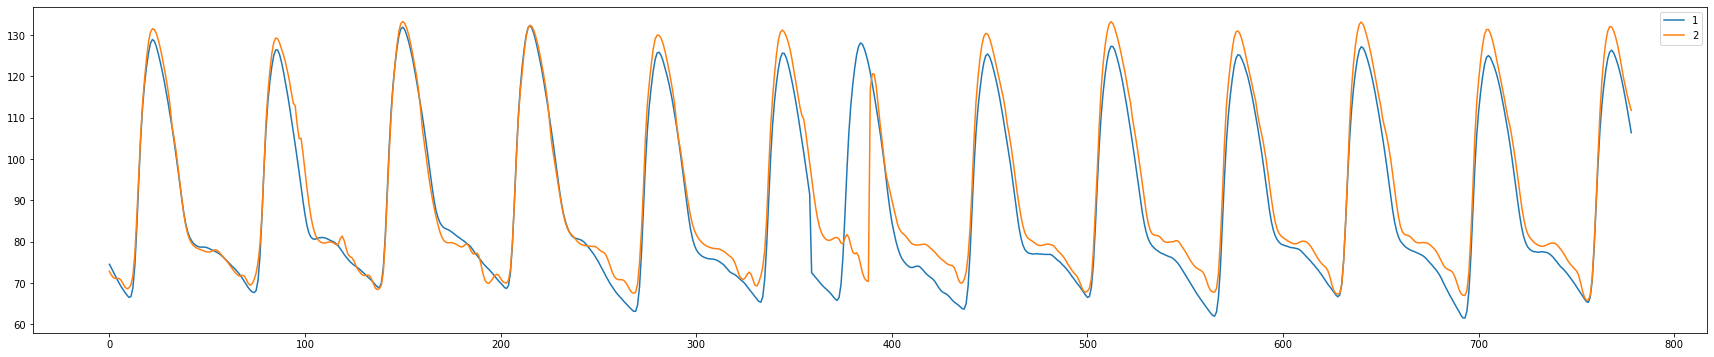

In [13]:
time_steps = 15
feature0 = np.column_stack((train_ppgs[0], train_ecgs[0])) 
bp0 = train_bps[0]
X_train0, y_train0 = reshape_data(feature0[:int(0.8*len(feature0))],bp0[:int(0.8*len(bp0))],time_steps)
model0 = bpwave_lstm_model(X_train0,y_train0,time_steps)

X_test0, y_test0 = reshape_data(feature0[int(0.8*len(feature0)):],bp0[int(0.8*len(bp0)):],time_steps)
y_pred0 = model0.predict(X_test0)
mae = np.mean(np.abs(y_pred0*250 - y_test0*250))
rmse = np.sqrt(np.mean((y_pred0*250-y_test0*250)**2))
print(f'MAE: {mae}, RMSE: {rmse}')
show_two(y_test0*250, y_pred0*250)